---
# Apples to Apples
### John Thurman
---

## Table of Contents
* #### [Introduction](#Introduction)
    * [Define functions](#DefineFunctions)
    * [Loading Data](#LoadingData)
    * [Data exploration](#DataExploration)
* #### [Modelling fruit 360 data](#ModellingSection1)
    * [Random Forest Benchmark](#Benchmark)
    * [2 Convolution CNN](#Model1)
    * [4 Convolution CNN](#Model2)
    * [Transfer learning](#Model3)
    * [General Comments](#Comments1)
* #### [Modelling flickr data](#ModellingSection2)
    * [4 Convolution CNN](#Model4)
    * [Transfer learning](#Model5)
    * [General Comments](#Comments2)
* #### [Reduced fruit subset](#ModellingSection3)
    * [4 Convolutions CNN](#Model6)
    * [Transfer learning](#Model7)
    * [Hyper-parameter tuning](#Hyperparam)
    * [General Comments](#Comments3)
* #### [Other](#Other)
    * [Image Augmentation](#ImageAugmentation)





Load the appropriate libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import pickle
import os
import glob

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy, sparse_top_k_categorical_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

print('Tensorflow version \t:', tf.__version__)
print(tf.test.is_gpu_available(), tf.test.is_built_with_cuda(), tf.test.gpu_device_name())

Using TensorFlow backend.
W0326 15:18:39.547686 21132 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Tensorflow version 	: 1.10.0
True True /device:GPU:0


<a id="Introduction"> </a>
# Introduction

The objective of this project is to determine whether image classification techniques can be used to distinguish between different types of fruit. The project looks at 4 general types of model:
* Random Forest Classifier (Used as a benchmark)
* A Convoltional Neural network (CNN) with 2 convolutional layers
* CNN with 4 convolutional layers
* CNN using transfer learning from a mobilenet (V2) model that has been trained on the Imagenet dataset.

The data used for this project has come from two sources:
* 'fruit-360' dataset produced by Horea Muresan, Mihai Oltean, and available at kaggle 
<a href='https://www.kaggle.com/moltean/fruits'> here </a> 
* A dataset that was compiled using the Flickr API with additional manual cleaning. A separate jupyter notebook has been included detailing the steps taken to collect this data

This project has been split into two sections, seperated by the two of data sources

<a id="DefineFunctions"></a>
# Defining useful functions 

These functions are used throughout the document in the analysis

In [2]:
#Metric for defining success. In addition to accr
def custom_accuracy(ytrue, ypred):
    '''
    An accuracy where we determine whether we manage to guess the product within the top 4 tries.
    '''
    return sparse_top_k_categorical_accuracy(ytrue, ypred, k=4)

# functions for plotting learning
def plt_history(history):
    '''
    For use with a keras based model.
    This model will plot the loss, accuracy and 'top4 accuracy' per epoch.
    '''
    
    plt.figure(figsize=[20,6]);
    for counter, metric in enumerate(['loss', 'acc', 'custom_accuracy']):
    
        val_metric = 'val_'+metric
        plt.subplot(1,3,counter+1)
        plt.plot(history.history[metric],'r',linewidth=3.0);
        plt.plot(history.history[val_metric],'b',linewidth=3.0);
        plt.legend(['Training '+ metric, 'Validation '+metric,],fontsize=18);
        plt.xlabel('Epochs ',fontsize=16);
        plt.ylabel(metric ,fontsize=16);
        plt.title(metric +' Curves',fontsize=16);   

def convert_to_supergroup(x):
    '''
    The fruit-360 data comes in 95 different varieties typically sub-species (e.g. Braeburn). The Flicker data comes
    just over 50 varieties typically super species (e.g. Apple). This converst sub-species to super specie.
    '''
    
    df_supergroup = pd.read_csv('./data/FruitCategories.csv')
    df_x = pd.DataFrame(x, columns=['SubCategory'])
    return list((pd.merge(df_x, df_supergroup, on='SubCategory', how='left').loc[:,'Category']).values)

def plot_first_group(data, prediction_labels, truth_labels, number=15):
    '''
    This draws the first n
    '''
    plt.figure(figsize=(20,10))
    for count, photo in enumerate(prediction_labels[:number]):
        rows = (number-1)//5+1
        plt.subplot(rows,5, count+1)
        b,g,r = cv2.split(data[count,:,:,:])       
        rgb_img = cv2.merge([r,g,b]) 
        plt.imshow(rgb_img)
        plt.title(photo+'({}) ' .format(truth_labels[count]))
 
def load_data(directory, maxData=None, randomState=1):
    '''
    Loads the different data sets from file. Smaller (random) subsets can be taken for experimenting by using the MaxData and 
    random state parameters
    '''
    #Get list of all images in directory
    imagePaths = glob.glob(directory+'/*/*.jpg', recursive=True)
    
    if maxData is not None:
        np.random.set_state=randomState
        imagePaths = np.random.choice(imagePaths,size=maxData)
          
    X =[]
    y =[]
    for path in imagePaths:
        label = path.split("\\")[-2]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        X.append(image)
        y.append(label)
        
    return np.array(X), np.array(y)

#### Flickr data

In [3]:
# load data
X_flickr, y_flickr = load_data('./data/flickr')
X_flickr = X_flickr/255

#Create the reduced dataset:
fruitsubset = ['Strawberry', 'Apple', 'Lemon', 'Orange', 'Mango', 'Banana', 'Grape', 'Passion Fruit', 'Peach', 'Pineapple', 'Lime']
infruitsubset = np.in1d(y_flickr, fruitsubset)
X_flickr_subset = X_flickr[infruitsubset]
y_flickr_subset = y_flickr[infruitsubset]

#need a new encoder as the data has different labels than the fruit 360 dataset
label_encoder_flickr = LabelEncoder()

#transformation on data
y_flickr = label_encoder_flickr.fit_transform(y_flickr)
X_flickr_train, X_flickr_test, y_flickr_train, y_flickr_test = train_test_split(X_flickr, y_flickr,  \
                                                                                test_size=0.1, train_size=0.9, stratify=y_flickr)
X_flickr_train, X_flickr_val, y_flickr_train, y_flickr_val = train_test_split(X_flickr_train, y_flickr_train, \
                                                                              test_size=0.2, train_size=0.8, stratify=y_flickr_train)

# Save the label encoder to use in predictions in a web app
fileObject = open('labelEncodingFlickr.pkl','wb')
pickle.dump(label_encoder_flickr,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKR = len(np.unique(y_flickr))

In [6]:
#need a new encoder as the data has different labels than the fruit 360 dataset (and smaller than the other flickr encoding)
label_encoder_flickr_subset = LabelEncoder()

#transformation on data
y_flickr_subset = label_encoder_flickr_subset.fit_transform(y_flickr_subset)
X_flickr_subset_train, X_flickr_subset_test, y_flickr_subset_train, y_flickr_subset_test = train_test_split(X_flickr_subset, y_flickr_subset,  test_size=0.1, train_size=0.9, stratify=y_flickr_subset)
X_flickr_subset_train, X_flickr_subset_val, y_flickr_subset_train, y_flickr_subset_val = train_test_split(X_flickr_subset_train, y_flickr_subset_train,  test_size=0.2, train_size=0.8, stratify=y_flickr_subset_train)

# Save the label encoder to use in predictions in a web app
fileObject = open('labelEncodingFlickrSubset.pkl','wb')
pickle.dump(label_encoder_flickr_subset,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKRSUBSET = len(np.unique(y_flickr_subset))

#To free up space as otherwise there is a duplication of this data
del X_flickr, y_flickr

<a id='Model1'> </a>
### AlexNet

In [4]:
#Define a model:
resize_layer = Lambda(lambda x: tf.image.resize_images(x, (224,224)), input_shape = (100,100,3))

model = Sequential()
model.add(Conv2D(64, (4, 4),strides=(2, 2), padding='same', activation='relu'))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 64)        23296     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 52, 128)       204928    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        18464     
__________

Train on 2605 samples, validate on 652 samples
Epoch 1/100
2605/2605 [==============================] - 9s 3ms/step - loss: 2.1903 - acc: 0.2303 - custom_accuracy: 0.6035 - val_loss: 1.9270 - val_acc: 0.3098 - val_custom_accuracy: 0.7331: 0.2150 -
Epoch 2/100
2605/2605 [==============================] - 6s 2ms/step - loss: 1.9352 - acc: 0.2990 - custom_accuracy: 0.7436 - val_loss: 1.8228 - val_acc: 0.3267 - val_custom_accuracy: 0.7914
Epoch 3/100
2605/2605 [==============================] - 6s 2ms/step - loss: 1.8716 - acc: 0.3036 - custom_accuracy: 0.7731 - val_loss: 1.7890 - val_acc: 0.3558 - val_custom_accuracy: 0.7807
Epoch 4/100
2605/2605 [==============================] - 6s 2ms/step - loss: 1.8266 - acc: 0.3363 - custom_accuracy: 0.7693 - val_loss: 1.7338 - val_acc: 0.3896 - val_custom_accuracy: 0.7929
Epoch 5/100
2605/2605 [==============================] - 6s 2ms/step - loss: 1.7794 - acc: 0.3536 - custom_accuracy: 0.7862 - val_loss: 1.7175 - val_acc: 0.3972 - val_custom_accur

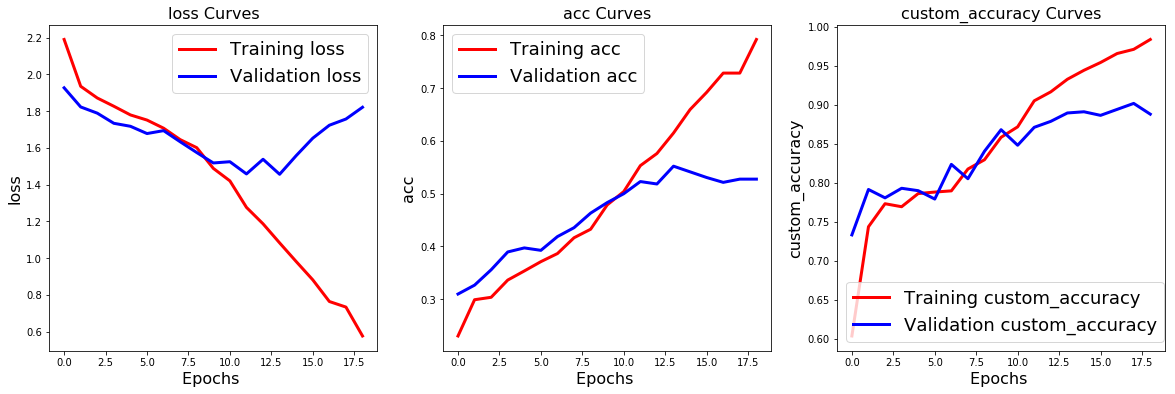

In [7]:
# training model with early stopping
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=5, verbose=0, mode='auto')
         
history = model.fit(X_flickr_subset_train, y_flickr_subset_train,
                    validation_data = (X_flickr_subset_val, y_flickr_subset_val),
                    callbacks = [cp_earlystop],
                    epochs=100, verbose=1)

#plot the training history
plt_history(history)

In [ ]:


# Note that the real life images have a different categories. Only the superclass (e.g. Apple) and not 
# the subclass (e.g. Braeburn) has been included
labels_predict = label_encoder.inverse_transform(model.predict_classes(X_flickr_subset_test))
labels_predict_flickr = list(convert_to_supergroup(labels_predict))
print('Accuracy \t: %.3f' % accuracy_score(labels_predict_flickr, label_encoder_flickr.inverse_transform(y_flickr_subset_test)))